In [2]:
from pathlib import Path
import sys
sys.path.append('../feature_table/bitome-kb/')
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.sparse as sparse
import seaborn as sns
from bitome.core import Bitome
from math import log,exp,inf
import pickle
from Bio.Seq import Seq
import xml.etree.ElementTree as ET
import subprocess

bitome = Bitome(Path('../feature_table/bitome-kb/data', 'NC_000913.3.gb'))
bitome.load_data(regulon_db=True)

/Users/ritawan/Projects/regulonML/Meme_LOO/bitome-kb/bitome/genbank.py:345: UserWarning: GEM-PRO sequence and coded sequence are not the same for b0064
  warn(f'GEM-PRO sequence and coded sequence are not the same for {locus_tag}')
/Users/ritawan/Projects/regulonML/Meme_LOO/bitome-kb/bitome/genbank.py:345: UserWarning: GEM-PRO sequence and coded sequence are not the same for b0142
  warn(f'GEM-PRO sequence and coded sequence are not the same for {locus_tag}')
/Users/ritawan/Projects/regulonML/Meme_LOO/bitome-kb/bitome/genbank.py:328: UserWarning: No GEM-PRO file found for b4586
  warn(f'No GEM-PRO file found for {locus_tag}')
/Users/ritawan/Projects/regulonML/Meme_LOO/bitome-kb/bitome/genbank.py:345: UserWarning: GEM-PRO sequence and coded sequence are not the same for b0292
  warn(f'GEM-PRO sequence and coded sequence are not the same for {locus_tag}')
/Users/ritawan/Projects/regulonML/Meme_LOO/bitome-kb/bitome/genbank.py:345: UserWarning: GEM-PRO sequence and coded sequence are not t

/Users/ritawan/Projects/regulonML/Meme_LOO/bitome-kb/bitome/genbank.py:345: UserWarning: GEM-PRO sequence and coded sequence are not the same for b2957
  warn(f'GEM-PRO sequence and coded sequence are not the same for {locus_tag}')
/Users/ritawan/Projects/regulonML/Meme_LOO/bitome-kb/bitome/genbank.py:345: UserWarning: GEM-PRO sequence and coded sequence are not the same for b3039
  warn(f'GEM-PRO sequence and coded sequence are not the same for {locus_tag}')
/Users/ritawan/Projects/regulonML/Meme_LOO/bitome-kb/bitome/genbank.py:345: UserWarning: GEM-PRO sequence and coded sequence are not the same for b3453
  warn(f'GEM-PRO sequence and coded sequence are not the same for {locus_tag}')
/Users/ritawan/Projects/regulonML/Meme_LOO/bitome-kb/bitome/genbank.py:328: UserWarning: No GEM-PRO file found for b4613
  warn(f'No GEM-PRO file found for {locus_tag}')
/Users/ritawan/Projects/regulonML/Meme_LOO/bitome-kb/bitome/genbank.py:345: UserWarning: GEM-PRO sequence and coded sequence are not t

In [3]:
from pymodulon.io import load_json_model
import pymodulon
# from pymodulon.visualization import *

# for plotting circos plot
# import pycircos
# import collections
# import matplotlib.pyplot as plt
# Garc    = pycircos.Garc
# Gcircle = pycircos.Gcircle

# 1. Load IM membership

In [4]:
import ast
im_info = pd.read_csv('../data/precise_1.0/precise1_im_info.csv')


In [5]:
IM_genes = {}
for i in range(len(im_info['im_name'])):
    IM_genes[im_info['im_name'][i]] = ast.literal_eval( im_info['genes'][i] )
IM_genes.keys()

dict_keys(['GlpR', 'DhaR/Mlc', 'ArgR', 'NarL', 'MalT', 'OxyR', 'Crp-2', 'AtoC', 'PurR-1', 'CsqR', 'MetJ', 'PurR-2', 'Cbl+CysB', 'GlcC', 'Crp-1', 'YiaJ', 'GcvA', 'XylR', 'RpoH', 'GadEWX', 'PrpR', 'GadWX', 'CecR', 'ArcA-1', 'Fnr', 'CdaR', 'Pyruvate', 'SrlR+GutM', 'NagC/TyrR', 'CpxR', 'Lrp', 'Leu/Ile', 'Fur-1', 'Thiamine', 'CysB', 'FliA', 'PuuR', 'NikR', 'NtrC+RpoN', 'RcsAB', 'His-tRNA', 'Fur-2', 'Copper', 'AllR/AraC/FucR', 'Cra', 'ArcA-2', 'EvgA', 'Zinc', 'SoxS', 'Nac', 'Tryptophan', 'FadR/IclR', 'FlhDC', 'GntR/TyrR', 'RpoS', 'ExuR/FucR', 'FecI', 'RbsR'])

# 2. Generate IM motif using LOO

In [6]:
with open('../data/precise_1.0/promoters_grouping_IM.pkl', 'rb') as f:
    IM_promoters = pickle.load(f)

## Helper functions

In [121]:
def score_motif(s, M):
    if len(s) != len(M):
        return -inf
    out = 0
    for i in range( len(s)):
        out = out + M[i][s[i]]
    return out

def combine_strings(strings, min_overlap):
    combined_strings = [strings[0]]  # Initialize a list to store the combined strings and add the first string
    for s in strings[1:]:  # Loop over the remaining strings
        overlap = 0  # Initialize the overlap counter to 0
        for i in range(min_overlap, min(len(s), len(combined_strings[-1])) + 1):  # Loop over the possible overlap lengths
            if s[:i] == combined_strings[-1][-i:]:  # Check if there is overlap between the current string and the last combined string
                overlap = i  # If there is overlap, update the overlap counter
        if overlap >= min_overlap:  # If there is overlap, combine the strings
            combined_strings[-1] += s[overlap:]  # Append the non-overlapping part of the current string to the last combined string
        else:  # If there is no overlap, add the current string to the list of combined strings
            combined_strings.append(s)
    return combined_strings  # Return the list of combined strings

## Generate promoter region fasta file

In [127]:
def promoter_region_generator_LOO(gene_list, search_range=(-150, 30), min_overlap=20):
    # generate a fasta file containing all the upstream region of given genes 
    
    # 150 upstream, 30 downstream

    tss_list = []
    strand_list = []
    for g in bitome.genes:
        if g.locus_tag in gene_list:
            for tu in g.transcription_units:
                if tu.tss != None:
                    tss_list.append(tu.tss)
                    strand_list.append(tu.location.strand)
    
    sorted_tss_list = sorted(list(set(tss_list)))                
    sorted_strand_list = [strand_list[tss_list.index(a)] for a in sorted_tss_list] 
    
    s_list = []
    for i in range(len(sorted_tss_list)):
        if sorted_strand_list[i] == 1:
            s = str(bitome.sequence)[ sorted_tss_list[i]+search_range[0]:sorted_tss_list[i]+search_range[1]]
        else:
            s = str(bitome.sequence)[ sorted_tss_list[i]-search_range[1]:sorted_tss_list[i]-search_range[0]]
            # reverse complement, meme is able to handle this
            s = Seq(s)
            s = str(s.reverse_complement())
            
        s_list.append(s)
    
    # remove duplicate string to avoid overfit, as some genes belongs to the same tu
    seen = []
    s_list = [x for x in s_list if x not in seen and not seen.append(x)]
    
    if s_list ==[]:
        return []
    
    s_combined_list = combine_strings(s_list, min_overlap = min_overlap)
    
    motif_file = open(r'motif_sequence.fasta', 'w+')
    out = '\n'.join(['>TSS' + str(i+1) + "\n" + j for i,j in enumerate(s_combined_list)])
    motif_file.write(out)
    motif_file.close()
    
    
    return s_combined_list

## Process Meme output

In [128]:
def meme_motif_extract(meme_xml_path="meme_out/meme.xml"):
    # Parse the MEME XML output file
    tree = ET.parse(meme_xml_path)
    root = tree.getroot()

    # Find the motif element with ID="1" (assumes the first motif)
    motif_element = root.find(".//motifs/motif[@id='motif_1']")
    sites_element = motif_element.find("contributing_sites")

    # Extract the motif scoring matrix as a string
    scores = motif_element.find("scores")
    scoring_list = scores.findall("alphabet_matrix/alphabet_array")

    scoring_matrix = []
    for row in scoring_list:
        scoring_dict = {"A": int(row.find("value[@letter_id='A']").text), 
                     "C": int(row.find("value[@letter_id='C']").text),
                     "G": int(row.find("value[@letter_id='G']").text),
                     "T": int(row.find("value[@letter_id='T']").text)
                    }
        scoring_matrix.append(scoring_dict)
    
    training_scores = []
    for contributing_site in sites_element.findall("contributing_site"):
        seq = ""
        site = contributing_site.find("site")
        for letter in site.findall("letter_ref"):
            seq = seq + letter.get('letter_id')

        training_scores.append(score_motif(seq, scoring_matrix))

    return training_scores, scoring_matrix

## Leave One Out

In [153]:
# output will be store in a fasta file that can be pasted to MEME
# The generated im motifs are stored in ../motif_logodds.txt

def Meme_LOO(IM_name, search_range=(-150, 30), pal=False, distr=False, min_overlap=20, mod='oops'):
    # if distribution==True, return a dict that contains all scores from -150 to 30 with gene id as rows.
    # if distribution==False, return the maximum screening scores as a list
    
    training_scores_all = []
    val_scores_all = []
    distribution = {}
    for i in range(len(IM_promoters[IM_name])):
        # Leave one out algorithm to generate the motif
        train_promoter_list = [x for j,x in enumerate(IM_promoters[IM_name]) if j!=i]
        train_gene_list = sum(train_promoter_list,[])
        s_list = promoter_region_generator_LOO(train_gene_list, search_range=search_range, min_overlap=min_overlap)
        if pal == True:
            cmd_list = ['meme', 'motif_sequence.fasta', '-dna', '-oc', 'meme_out', '-time', '14400', '-mod', 
                mod, '-nmotifs', '1', '-minw', '6', '-maxw', '50', '-revcomp', '-pal']
        else:
            cmd_list = ['meme', 'motif_sequence.fasta', '-dna', '-oc', 'meme_out', '-time', '14400', '-mod', 
                mod, '-nmotifs', '1', '-minw', '6', '-maxw', '50', '-revcomp']
        subprocess.call(cmd_list)
        
        training_scores, scoring_matrix = meme_motif_extract()
        
        # do not combine overlap promoter region for val_seq 
        val_seq = promoter_region_generator_LOO(IM_promoters[IM_name][i], search_range=search_range, min_overlap=120)
        
        if val_seq == []:
            continue
        
        val_scores = []
        val_scores_dist = []

        #print(val_seq)
        for seq in val_seq:
            scores = []
            motif_len = len(scoring_matrix)
            for j in range(0, len(seq)+1 - motif_len):
                scores.append( score_motif(seq[j:j+motif_len], scoring_matrix) )
                
            val_scores.append(max(scores))
            val_scores_dist.append(scores)
            
        val_scores_all.append(val_scores)   
        training_scores_all.append(training_scores)
        
        distribution[tuple(IM_promoters[IM_name][i])] = val_scores_dist
    
    if distr==True:
        val_scores_all = distribution
    
    return training_scores_all, val_scores_all

In [154]:
excluded = ['Leu/Ile','Tryptophan','His-tRNA', 'Thiamine']

# 3. Boxplot

In [155]:
plot_df = pd.DataFrame(columns=['IM', 'val_scores'])
val_scores_all = []
IM_names = []
for IM_name in IM_genes.keys():
    if IM_name in excluded:
        continue
    training_scores, val_scores = Meme_LOO(IM_name, search_range=(-150, 30))
    val_scores = sum(val_scores, [])
    val_scores_all.append(val_scores)
    IM_names.append(IM_name)
plot_df['IM'] = IM_names
plot_df['val_scores'] = val_scores_all
#sns.boxplot(x=1, y=np.array(val_scores), errcolor="black")

Writing results to output directory 'meme_out'.
Initializing the motif probability tables for 2 to 3 sites...
nsites = 3
Done initializing.
SEEDS: highwater mark: seq 2 pos 180

seqs=     3, min= 180, max=  180, total=      540

motif=1
SEED WIDTHS: 6 8 11 15 21 29 41 50
em: w=  50, psites=   3, iter=   0  
The output directory 'meme_out' already exists.
Its contents will be overwritten.
Initializing the motif probability tables for 2 to 3 sites...
nsites = 3
Done initializing.
SEEDS: highwater mark: seq 2 pos 180

seqs=     3, min= 180, max=  180, total=      540

motif=1
SEED WIDTHS: 6 8 11 15 21 29 41 50
em: w=  50, psites=   3, iter=   0 Warning: conversion to png format using Ghostscript failed.



KeyboardInterrupt: 

<Axes: >

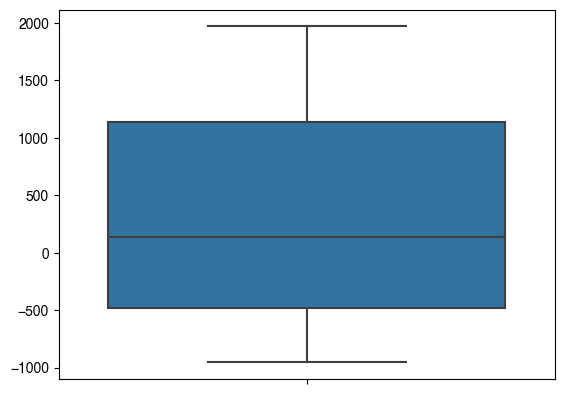

In [108]:
sns.boxplot(y=np.array(plot_df[plot_df['IM']=='Crp-2']['val_scores'].iloc[0]), orient='v')

# 4. Generate Split motif

In [156]:
def meme_motif_extract_split(meme_xml_path="meme_out/meme.xml", spacer_len=4):
    # Parse the MEME XML output file
    tree = ET.parse(meme_xml_path)
    root = tree.getroot()

    # Find the motif element with ID="1" (assumes the first motif)
    motif_element = root.find(".//motifs/motif[@id='motif_1']")
    sites_element = motif_element.find("contributing_sites")

    # Extract the motif scoring matrix as a string
    scores = motif_element.find("scores")
    scoring_list = scores.findall("alphabet_matrix/alphabet_array")

    scoring_matrix = []
    for row in scoring_list:
        scoring_dict = {"A": int(row.find("value[@letter_id='A']").text), 
                     "C": int(row.find("value[@letter_id='C']").text),
                     "G": int(row.find("value[@letter_id='G']").text),
                     "T": int(row.find("value[@letter_id='T']").text)
                    }
        scoring_matrix.append(scoring_dict)
    
    if len(scoring_matrix) % 2 == 0:
        split_matrix = scoring_matrix[:int(len(scoring_matrix)/2)]
        split_matrix_inverted = scoring_matrix[int(len(scoring_matrix)/2):]
    
    else:
        # of the palidrome motif is odd number, omit the middle base pair
        split_matrix = scoring_matrix[:int(len(scoring_matrix)/2)]
        split_matrix_inverted = scoring_matrix[int(len(scoring_matrix)/2)+1:]
        
    ## remove the spacer from the matrix
    split_matrix = split_matrix[:int(-spacer_len/2)]
    split_matrix_inverted = split_matrix_inverted[int(spacer_len/2):]
        
#     training_scores = []
#     for contributing_site in sites_element.findall("contributing_site"):
#         seq = ""
#         site = contributing_site.find("site")
#         for letter in site.findall("letter_ref"):
#             seq = seq + letter.get('letter_id')

#         training_scores.append(score_motif(seq, scoring_matrix))

#     return training_scores, scoring_matrix

    return split_matrix, split_matrix_inverted

In [157]:
# output will be store in a fasta file that can be pasted to MEME
# The generated im motifs are stored in ../motif_logodds.txt

def Meme_LOO_split(IM_name, search_range=(-150, 30), pal=True, spacer_len=4, min_overlap=20, mod='oops'):
    # if distribution==True, return a dict that contains all scores from -150 to 30 with gene id as rows.
    # if distribution==False, return the maximum screening scores as a list
    
    training_scores_all = []
    val_scores_all = []
    distribution = {}
    for i in range(len(IM_promoters[IM_name])):
        
        # Leave one out algorithm to generate the motif
        train_promoter_list = [x for j,x in enumerate(IM_promoters[IM_name]) if j!=i]
        train_gene_list = sum(train_promoter_list,[])
        s_list = promoter_region_generator_LOO(train_gene_list, search_range=search_range, min_overlap=min_overlap)
        if pal == True:
            cmd_list = ['meme', 'motif_sequence.fasta', '-dna', '-oc', 'meme_out', '-time', '14400', '-mod', 
                mod, '-nmotifs', '1', '-minw', '6', '-maxw', '50', '-revcomp', '-pal']
        else:
            cmd_list = ['meme', 'motif_sequence.fasta', '-dna', '-oc', 'meme_out', '-time', '14400', '-mod', 
                mod, '-nmotifs', '1', '-minw', '6', '-maxw', '50', '-revcomp']
        subprocess.call(cmd_list)
        
#         training_scores, scoring_matrix = meme_motif_extract()

        split_matrix, split_matrix_inverted = meme_motif_extract_split(spacer_len=spacer_len)  
        
        val_seq = promoter_region_generator_LOO(IM_promoters[IM_name][i], search_range=search_range, min_overlap=120)
        
        
        if val_seq == []:
            continue
        
        val_scores = []
        
        val_scores_dist = []
        val_scores_dist_inverted = []

        #print(val_seq)
        for seq in val_seq:
            scores = []
            scores_inverted = []
            motif_len = len(split_matrix)
            motif_len_inverted = len(split_matrix_inverted)
            
            for j in range(0, len(seq)+1 - motif_len):
                scores.append( score_motif(seq[j:j+motif_len], split_matrix) )
            for j in range(0, len(seq)+1 - motif_len_inverted):
                scores_inverted.append( score_motif(seq[j:j+motif_len_inverted], split_matrix_inverted) )
                
#             val_scores.append(max(scores))
            val_scores_dist.append(scores)
            val_scores_dist_inverted.append(scores_inverted)
            
#         val_scores_all.append(val_scores)   
        
#         training_scores_all.append(training_scores)
        
        distribution[tuple(IM_promoters[IM_name][i])] = {"D": val_scores_dist, "I": val_scores_dist_inverted}
    
#     if distr==True:
#         val_scores_all = distribution
    
#     return training_scores_all, val_scores_all
    return distribution

In [141]:
distribution = Meme_LOO_split('Crp-2')

The output directory 'meme_out' already exists.
Its contents will be overwritten.
Initializing the motif probability tables for 4 to 40 sites...
nsites = 40
Done initializing.
SEEDS: highwater mark: seq 19 pos 180

seqs=    20, min= 180, max=  320, total=     3740

motif=1
SEED WIDTHS: 6 7 8 9 11 12 15 16 21 22 29 30 41 42 50 51
em: w=  51, psites=  20, iter=  30   
The output directory 'meme_out' already exists.
Its contents will be overwritten.
Initializing the motif probability tables for 4 to 42 sites...
nsites = 42
Done initializing.
SEEDS: highwater mark: seq 20 pos 180

seqs=    21, min= 180, max=  180, total=     3780

motif=1
SEED WIDTHS: 6 7 8 9 11 12 15 16 21 22 29 30 41 42 50 51
em: w=  51, psites=  21, iter=  20   
The output directory 'meme_out' already exists.
Its contents will be overwritten.
Initializing the motif probability tables for 4 to 42 sites...
nsites = 42
Done initializing.
SEEDS: highwater mark: seq 20 pos 180

seqs=    21, min= 180, max=  320, total=     39

In [142]:
with open('data/Crp2_IM_motif_split_pal.pkl', 'wb') as f:
    pickle.dump(distribution, f)

# 5. Crp with and without pal

## Crp-2

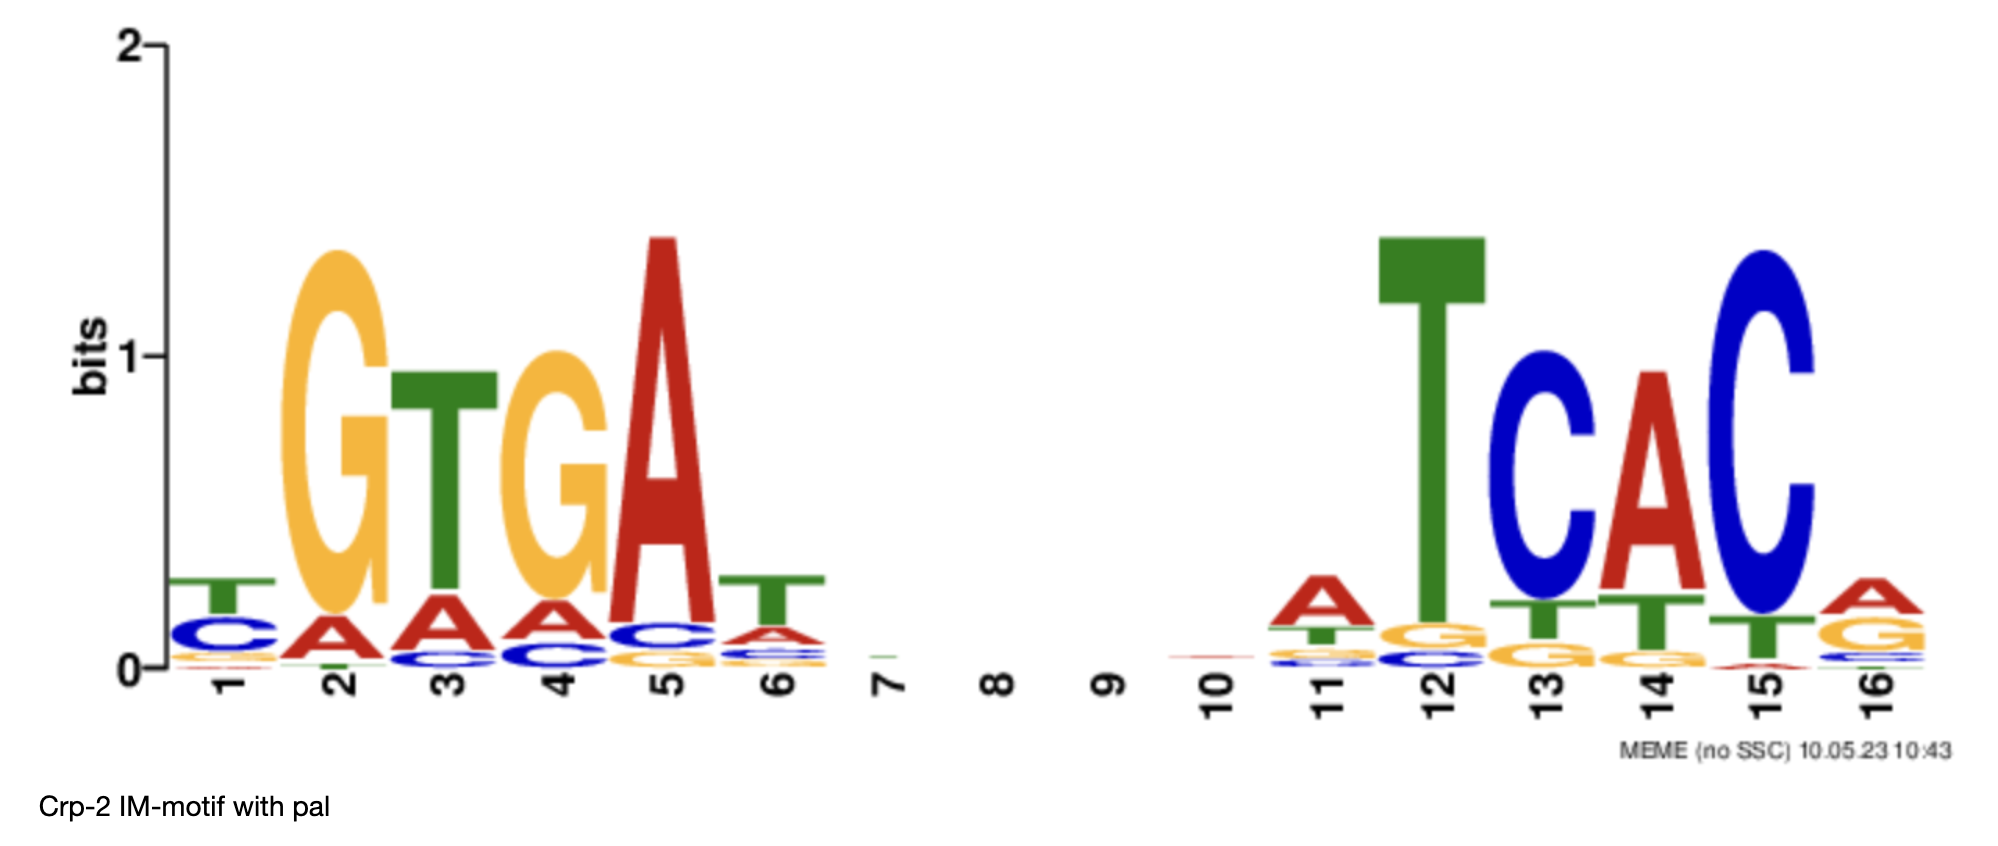
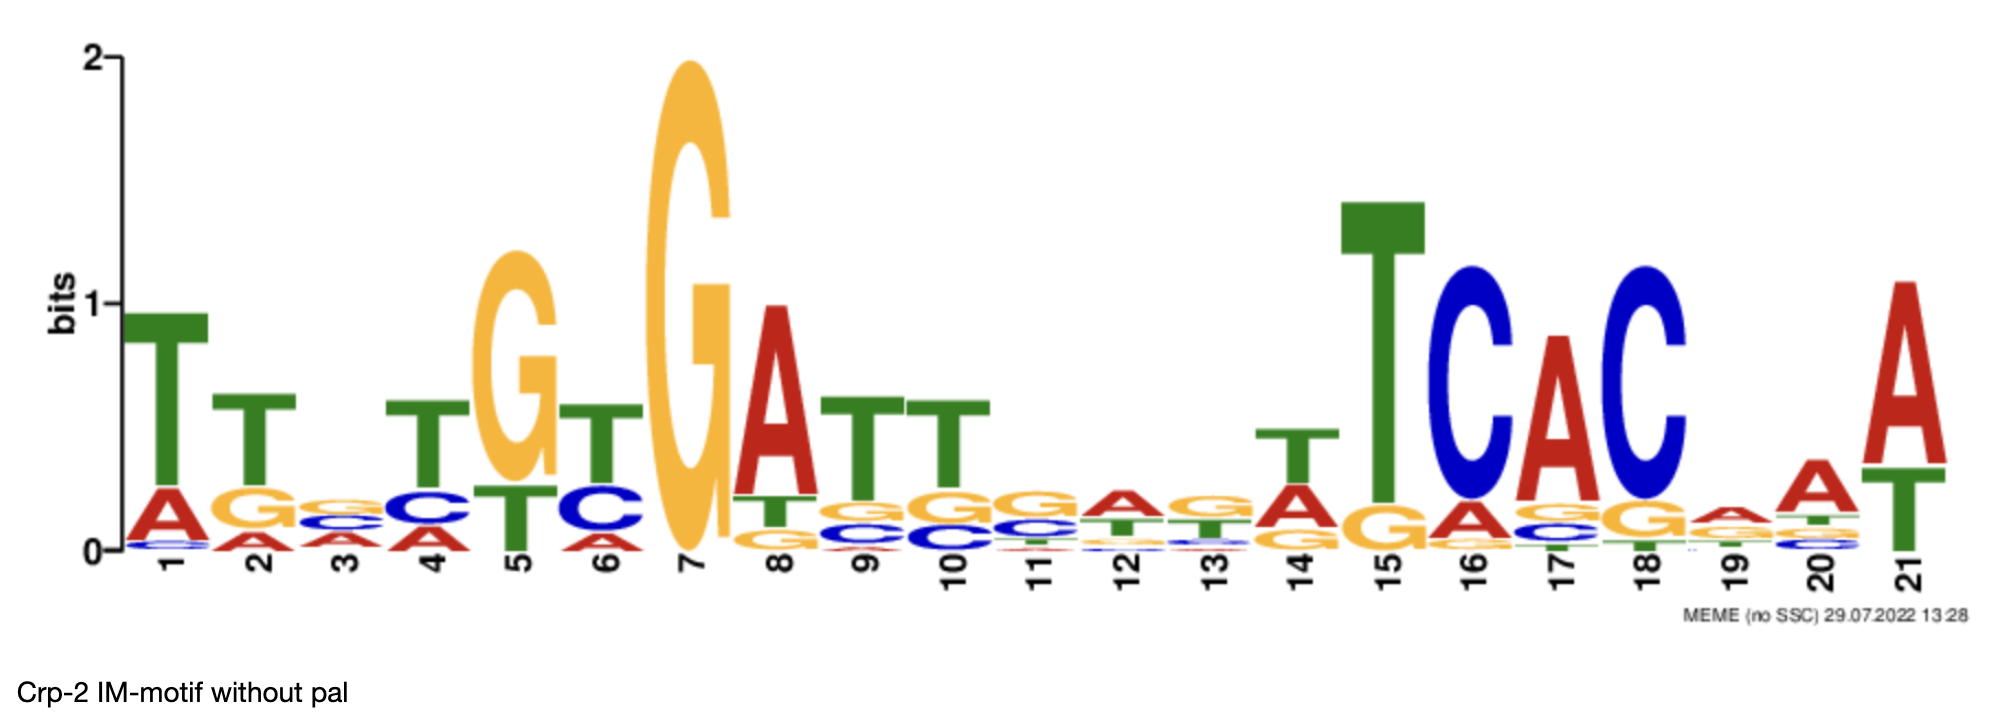
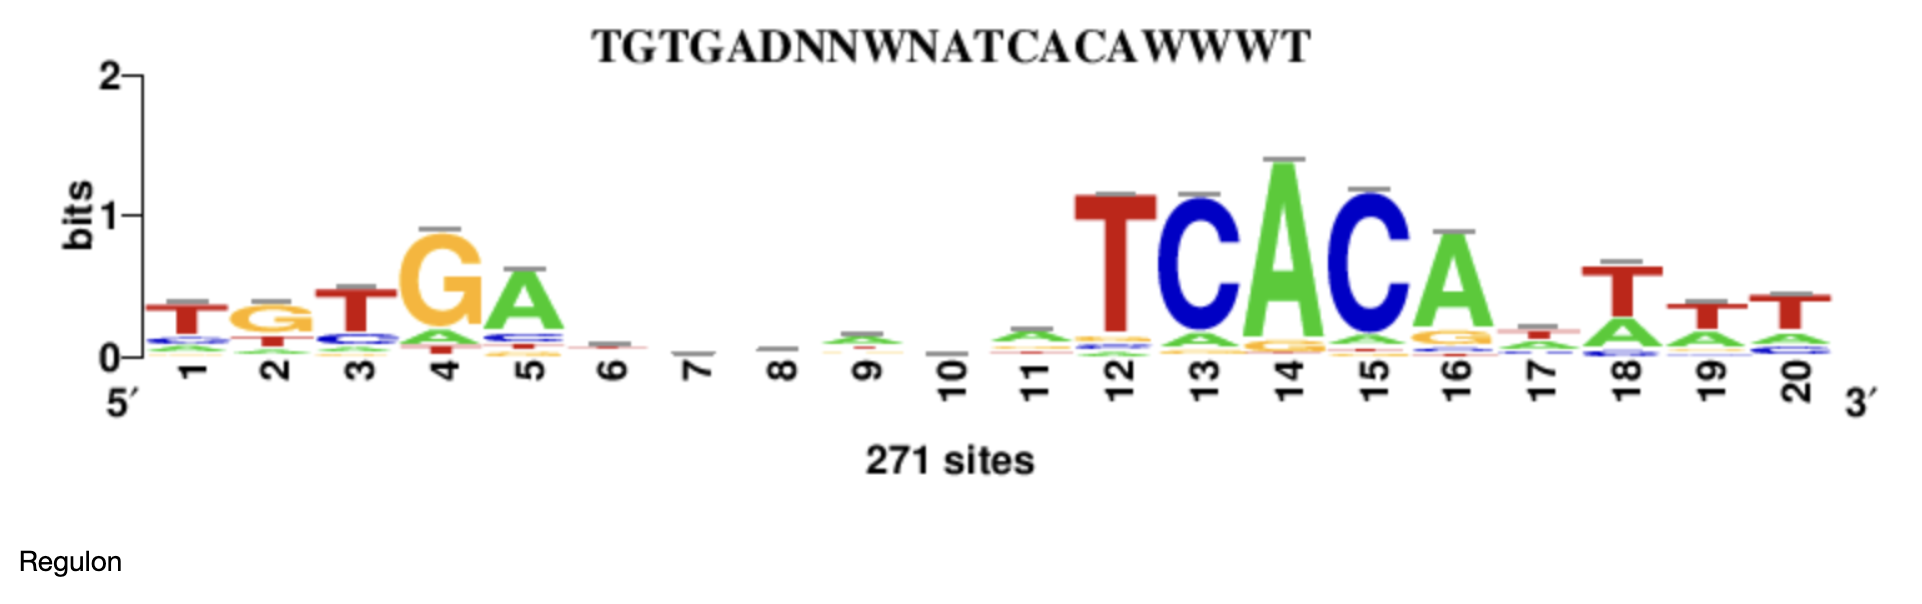

In [143]:
training_scores, val_scores = Meme_LOO('Crp-2', pal=False, distr=False, min_overlap=50)
training_scores_pal, val_scores_pal = Meme_LOO('Crp-2', pal=True, distr=False, min_overlap=50)

The output directory 'meme_out' already exists.
Its contents will be overwritten.
Initializing the motif probability tables for 2 to 21 sites...
nsites = 21
Done initializing.
SEEDS: highwater mark: seq 20 pos 180

seqs=    21, min= 180, max=  180, total=     3780

motif=1
SEED WIDTHS: 6 8 11 15 21 29 41 50
em: w=  50, psites=  21, iter=   0   
The output directory 'meme_out' already exists.
Its contents will be overwritten.
Initializing the motif probability tables for 2 to 21 sites...
nsites = 21
Done initializing.
SEEDS: highwater mark: seq 20 pos 180

seqs=    21, min= 180, max=  180, total=     3780

motif=1
SEED WIDTHS: 6 8 11 15 21 29 41 50
em: w=  50, psites=  21, iter=  10   
The output directory 'meme_out' already exists.
Its contents will be overwritten.
Initializing the motif probability tables for 2 to 22 sites...
nsites = 22
Done initializing.
SEEDS: highwater mark: seq 21 pos 180

seqs=    22, min= 180, max=  180, total=     3960

motif=1
SEED WIDTHS: 6 8 11 15 21 29 41 

em: w=  51, psites=  22, iter=  30   
The output directory 'meme_out' already exists.
Its contents will be overwritten.
Initializing the motif probability tables for 4 to 42 sites...
nsites = 42
Done initializing.
SEEDS: highwater mark: seq 20 pos 180

seqs=    21, min= 180, max=  180, total=     3780

motif=1
SEED WIDTHS: 6 7 8 9 11 12 15 16 21 22 29 30 41 42 50 51
em: w=  51, psites=  21, iter=  10   
The output directory 'meme_out' already exists.
Its contents will be overwritten.
Initializing the motif probability tables for 4 to 44 sites...
nsites = 44
Done initializing.
SEEDS: highwater mark: seq 21 pos 180

seqs=    22, min= 180, max=  180, total=     3960

motif=1
SEED WIDTHS: 6 7 8 9 11 12 15 16 21 22 29 30 41 42 50 51
em: w=  51, psites=  22, iter=  40   
The output directory 'meme_out' already exists.
Its contents will be overwritten.
Initializing the motif probability tables for 4 to 42 sites...
nsites = 42
Done initializing.
SEEDS: highwater mark: seq 20 pos 180

seqs=    

<Axes: >

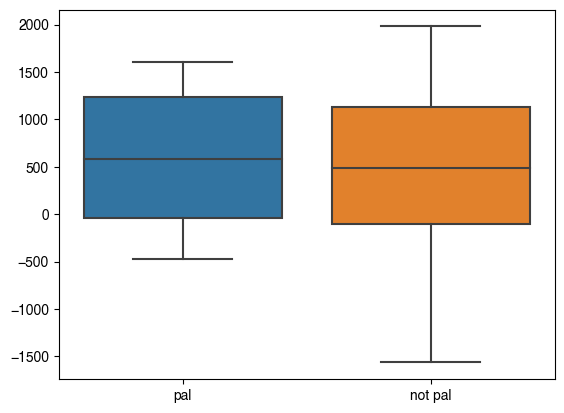

In [144]:
pal = sum(val_scores_pal, [])
pal_x = ['pal'] * len(pal)
no_pal = sum(val_scores, [])
no_pal_x = ['not pal'] * len(no_pal)

sns.boxplot(x=pal_x+no_pal_x, y=pal+no_pal)

In [145]:
training_scores, val_scores = Meme_LOO('Crp-2', pal=False, distr=True, min_overlap=50)
training_scores_pal, val_scores_pal = Meme_LOO('Crp-2', pal=True, distr=True, min_overlap=50)

with open('data/Crp2_IM_motif_pal.pkl', 'wb') as f:
    pickle.dump(val_scores_pal, f)
with open('data/Crp2_IM_motif.pkl', 'wb') as f:
    pickle.dump(val_scores, f)

The output directory 'meme_out' already exists.
Its contents will be overwritten.
Initializing the motif probability tables for 2 to 21 sites...
nsites = 21
Done initializing.
SEEDS: highwater mark: seq 20 pos 180

seqs=    21, min= 180, max=  180, total=     3780

motif=1
SEED WIDTHS: 6 8 11 15 21 29 41 50
em: w=  50, psites=  21, iter=   0   
The output directory 'meme_out' already exists.
Its contents will be overwritten.
Initializing the motif probability tables for 2 to 21 sites...
nsites = 21
Done initializing.
SEEDS: highwater mark: seq 20 pos 180

seqs=    21, min= 180, max=  180, total=     3780

motif=1
SEED WIDTHS: 6 8 11 15 21 29 41 50
em: w=  50, psites=  21, iter=  10   
The output directory 'meme_out' already exists.
Its contents will be overwritten.
Initializing the motif probability tables for 2 to 22 sites...
nsites = 22
Done initializing.
SEEDS: highwater mark: seq 21 pos 180

seqs=    22, min= 180, max=  180, total=     3960

motif=1
SEED WIDTHS: 6 8 11 15 21 29 41 

em: w=  51, psites=  22, iter=  30   
The output directory 'meme_out' already exists.
Its contents will be overwritten.
Initializing the motif probability tables for 4 to 42 sites...
nsites = 42
Done initializing.
SEEDS: highwater mark: seq 20 pos 180

seqs=    21, min= 180, max=  180, total=     3780

motif=1
SEED WIDTHS: 6 7 8 9 11 12 15 16 21 22 29 30 41 42 50 51
em: w=  51, psites=  21, iter=  10   
The output directory 'meme_out' already exists.
Its contents will be overwritten.
Initializing the motif probability tables for 4 to 44 sites...
nsites = 44
Done initializing.
SEEDS: highwater mark: seq 21 pos 180

seqs=    22, min= 180, max=  180, total=     3960

motif=1
SEED WIDTHS: 6 7 8 9 11 12 15 16 21 22 29 30 41 42 50 51
em: w=  51, psites=  22, iter=  40   
The output directory 'meme_out' already exists.
Its contents will be overwritten.
Initializing the motif probability tables for 4 to 42 sites...
nsites = 42
Done initializing.
SEEDS: highwater mark: seq 20 pos 180

seqs=    

## Crp-1

In [146]:
training_scores, val_scores = Meme_LOO('Crp-1', pal=False)
training_scores_pal, val_scores_pal = Meme_LOO('Crp-1', pal=True)

The output directory 'meme_out' already exists.
Its contents will be overwritten.
Initializing the motif probability tables for 2 to 35 sites...
nsites = 35
Done initializing.
SEEDS: highwater mark: seq 34 pos 180

seqs=    35, min= 180, max=  289, total=     6500

motif=1
SEED WIDTHS: 6 8 11 15 21 29 41 50
em: w=  50, psites=  35, iter=  40   
The output directory 'meme_out' already exists.
Its contents will be overwritten.
Initializing the motif probability tables for 2 to 35 sites...
nsites = 35
Done initializing.
SEEDS: highwater mark: seq 34 pos 180

seqs=    35, min= 180, max=  289, total=     6482

motif=1
SEED WIDTHS: 6 8 11 15 21 29 41 50
em: w=  50, psites=  35, iter=  20   
The output directory 'meme_out' already exists.
Its contents will be overwritten.
Initializing the motif probability tables for 2 to 36 sites...
nsites = 36
Done initializing.
SEEDS: highwater mark: seq 35 pos 180

seqs=    36, min= 180, max=  289, total=     6680

motif=1
SEED WIDTHS: 6 8 11 15 21 29 41 

em: w=  50, psites=  35, iter=  10   
The output directory 'meme_out' already exists.
Its contents will be overwritten.
Initializing the motif probability tables for 2 to 33 sites...
nsites = 33
Done initializing.
SEEDS: highwater mark: seq 32 pos 180

seqs=    33, min= 180, max=  289, total=     6140

motif=1
SEED WIDTHS: 6 8 11 15 21 29 41 50
em: w=  50, psites=  33, iter=  10   
The output directory 'meme_out' already exists.
Its contents will be overwritten.
Initializing the motif probability tables for 2 to 35 sites...
nsites = 35
Done initializing.
SEEDS: highwater mark: seq 34 pos 180

seqs=    35, min= 180, max=  289, total=     6500

motif=1
SEED WIDTHS: 6 8 11 15 21 29 41 50
em: w=  50, psites=  35, iter=  30   
The output directory 'meme_out' already exists.
Its contents will be overwritten.
Initializing the motif probability tables for 2 to 34 sites...
nsites = 34
Done initializing.
SEEDS: highwater mark: seq 33 pos 180

seqs=    34, min= 180, max=  289, total=     6320

mo

em: w=  51, psites=  35, iter=  40   
The output directory 'meme_out' already exists.
Its contents will be overwritten.
Initializing the motif probability tables for 4 to 68 sites...
nsites = 68
Done initializing.
SEEDS: highwater mark: seq 33 pos 180

seqs=    34, min= 180, max=  289, total=     6320

motif=1
SEED WIDTHS: 6 7 8 9 11 12 15 16 21 22 29 30 41 42 50 51
em: w=  51, psites=  34, iter=  40   
The output directory 'meme_out' already exists.
Its contents will be overwritten.
Initializing the motif probability tables for 4 to 70 sites...
nsites = 70
Done initializing.
SEEDS: highwater mark: seq 34 pos 180

seqs=    35, min= 180, max=  289, total=     6500

motif=1
SEED WIDTHS: 6 7 8 9 11 12 15 16 21 22 29 30 41 42 50 51
em: w=  51, psites=  35, iter=  40   
The output directory 'meme_out' already exists.
Its contents will be overwritten.
Initializing the motif probability tables for 4 to 70 sites...
nsites = 70
Done initializing.
SEEDS: highwater mark: seq 34 pos 180

seqs=    

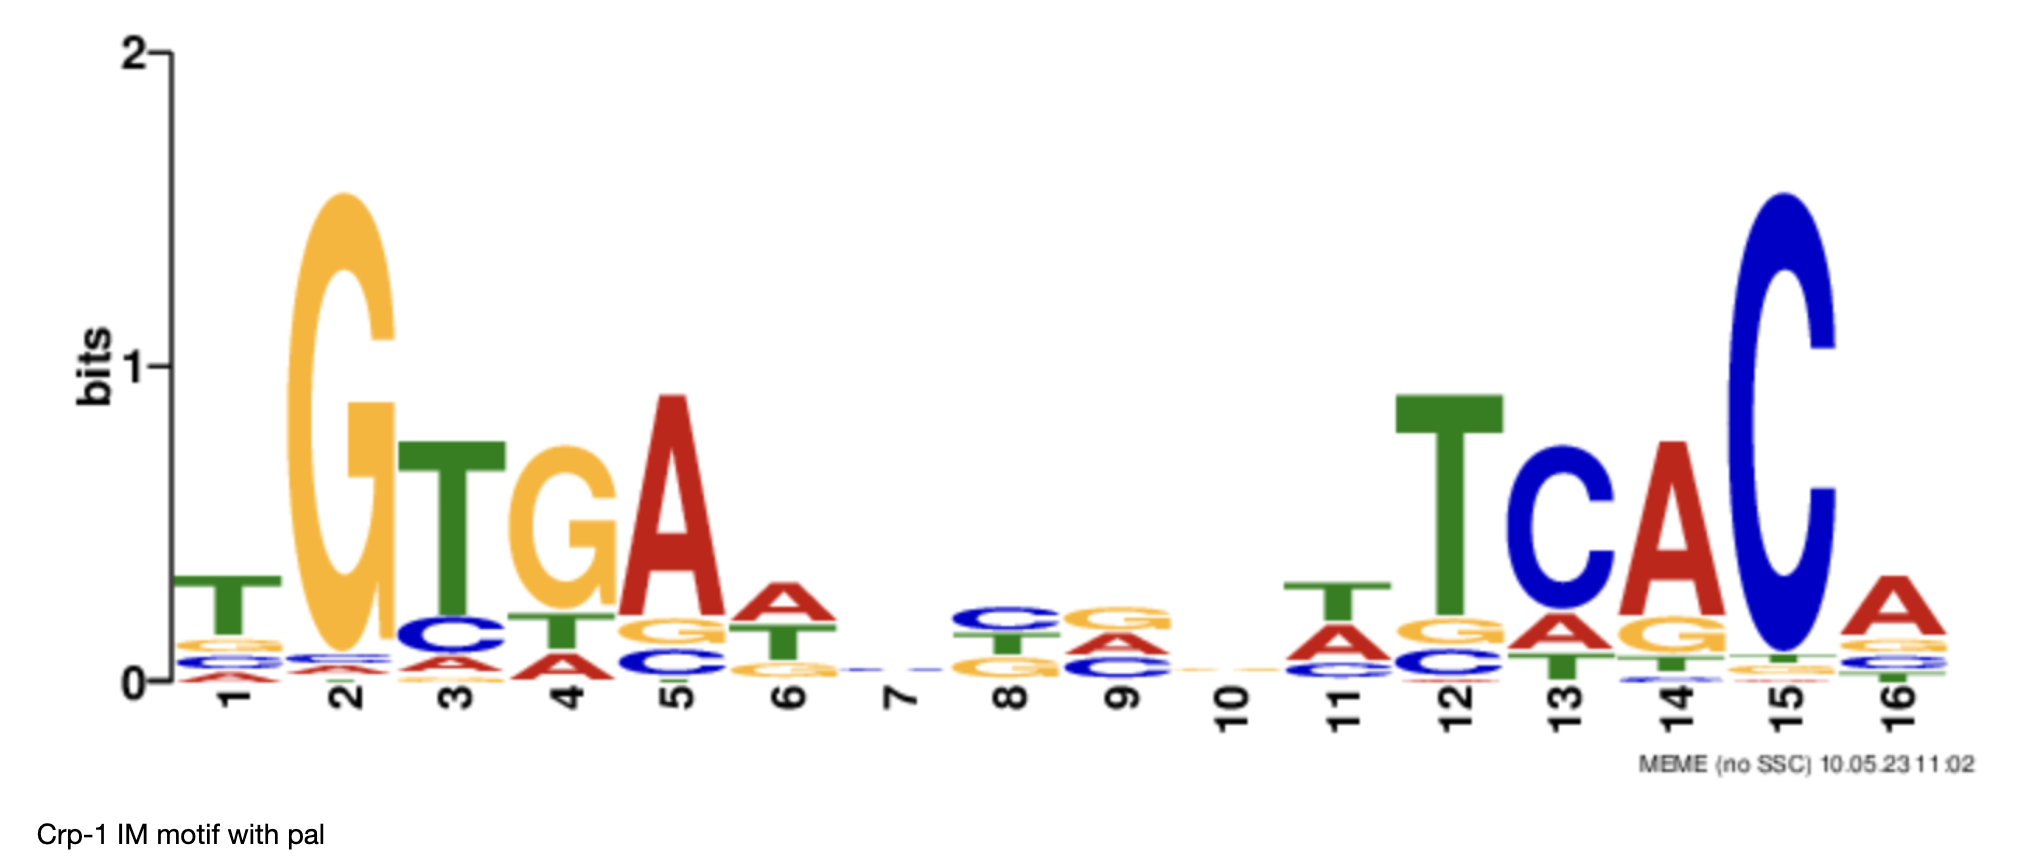
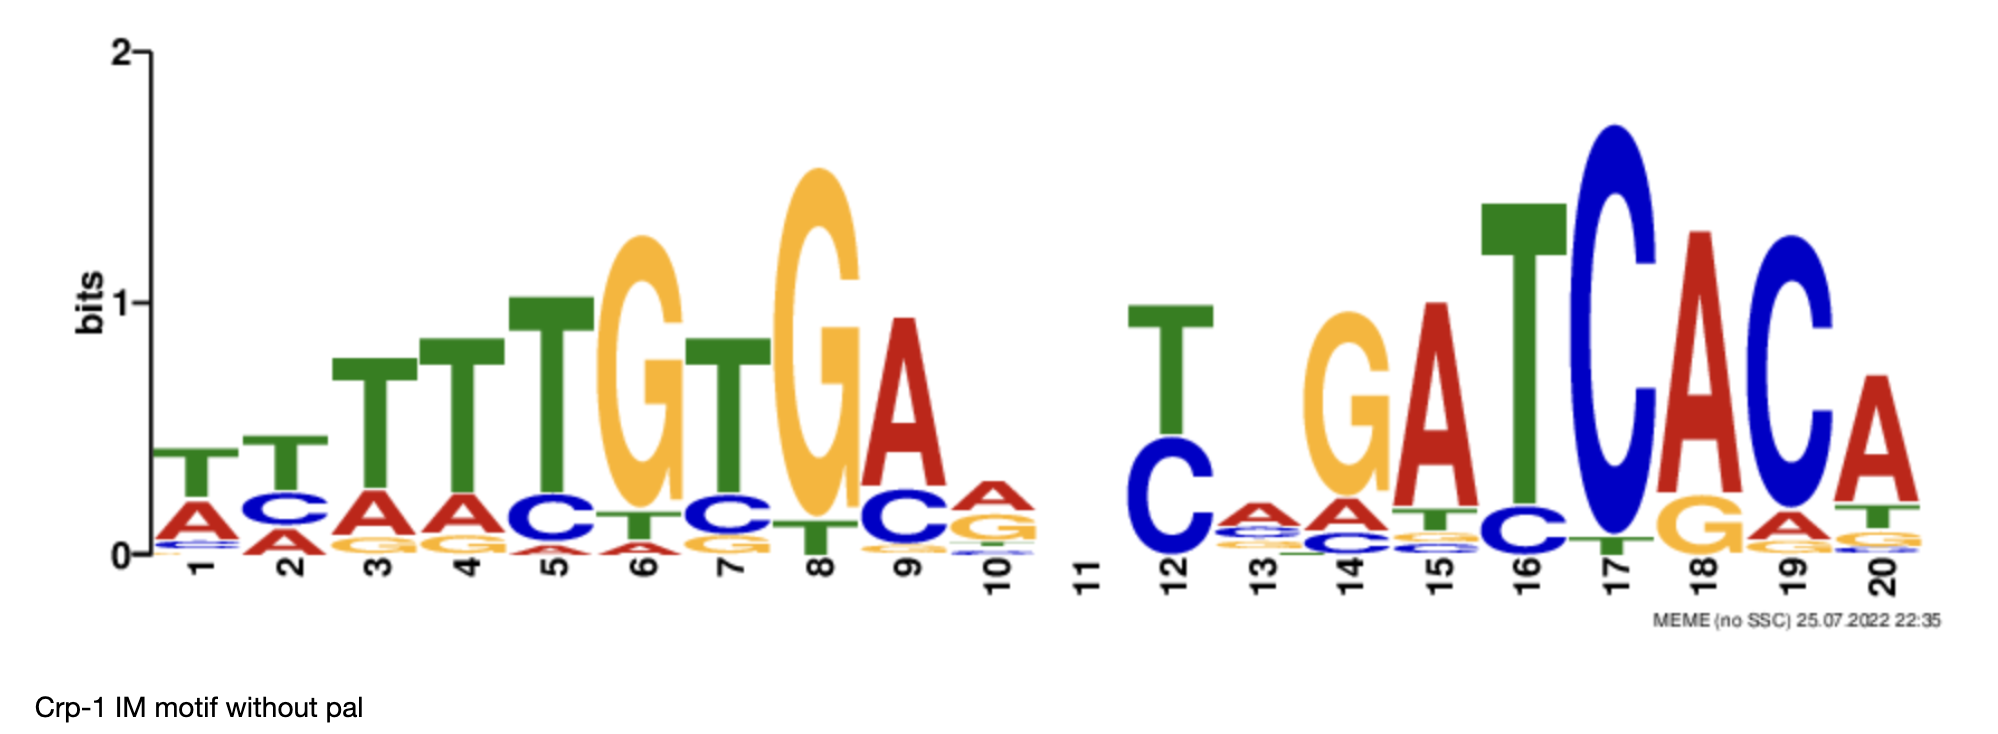
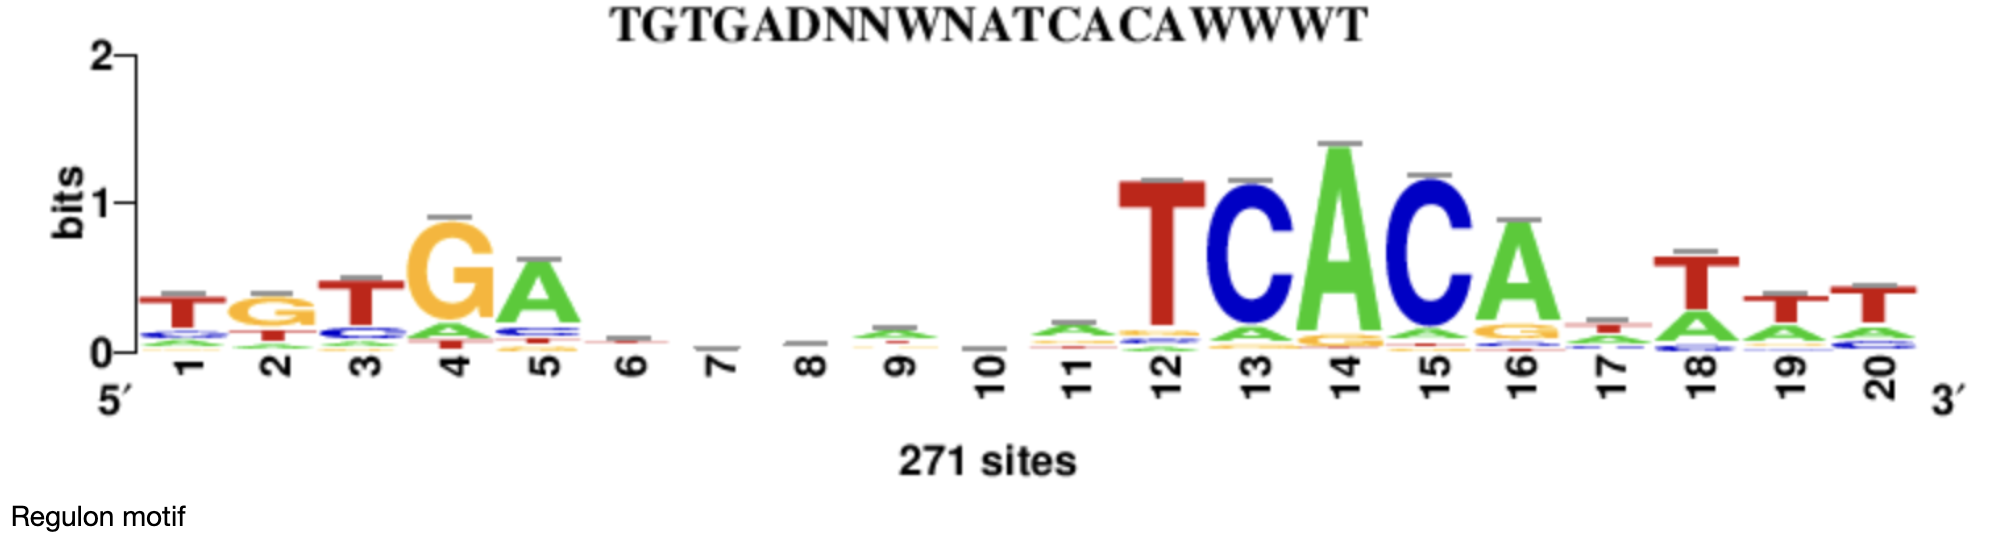

<Axes: >

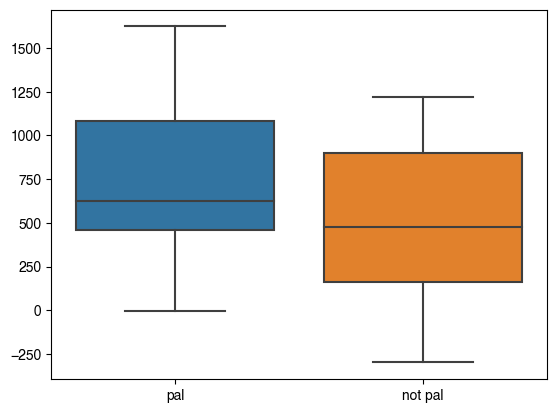

In [147]:
pal = sum(val_scores_pal, [])
pal_x = ['pal'] * len(pal)
no_pal = sum(val_scores, [])
no_pal_x = ['not pal'] * len(no_pal)
sns.boxplot(x=pal_x+no_pal_x, y=pal+no_pal)

## Lrp

In [159]:
training_scores, val_scores = Meme_LOO('Lrp', pal=False, mod='anr')
training_scores_pal, val_scores_pal = Meme_LOO('Lrp', pal=True, mod='anr')

The output directory 'meme_out' already exists.
Its contents will be overwritten.
Initializing the motif probability tables for 2 to 50 sites...
nsites = 50
Done initializing.
SEEDS: highwater mark: seq 18 pos 209

seqs=    19, min= 180, max=  209, total=     3449

motif=1
SEED WIDTHS: 6 8 11 15 21 29 41 50
em: w=  50, psites=  32, iter=   0   
The output directory 'meme_out' already exists.
Its contents will be overwritten.
Initializing the motif probability tables for 2 to 50 sites...
nsites = 50
Done initializing.
SEEDS: highwater mark: seq 18 pos 360

seqs=    19, min= 180, max=  360, total=     3600

motif=1
SEED WIDTHS: 6 8 11 15 21 29 41 50
em: w=  50, psites=  50, iter=  20   
The output directory 'meme_out' already exists.
Its contents will be overwritten.
Initializing the motif probability tables for 2 to 50 sites...
nsites = 50
Done initializing.
SEEDS: highwater mark: seq 18 pos 360

seqs=    19, min= 180, max=  360, total=     3629

motif=1
SEED WIDTHS: 6 8 11 15 21 29 41 

em: w=  51, psites=  50, iter=  20   
The output directory 'meme_out' already exists.
Its contents will be overwritten.
Initializing the motif probability tables for 4 to 100 sites...
nsites = 100
Done initializing.
SEEDS: highwater mark: seq 18 pos 360

seqs=    19, min= 180, max=  360, total=     3629

motif=1
SEED WIDTHS: 6 7 8 9 11 12 15 16 21 22 29 30 41 42 50 51
em: w=  51, psites=  50, iter=  40   
The output directory 'meme_out' already exists.
Its contents will be overwritten.
Initializing the motif probability tables for 4 to 100 sites...
nsites = 100
Done initializing.
SEEDS: highwater mark: seq 17 pos 209

seqs=    18, min= 180, max=  360, total=     3449

motif=1
SEED WIDTHS: 6 7 8 9 11 12 15 16 21 22 29 30 41 42 50 51
em: w=  51, psites=  32, iter=  30   
The output directory 'meme_out' already exists.
Its contents will be overwritten.
Initializing the motif probability tables for 4 to 100 sites...
nsites = 100
Done initializing.
SEEDS: highwater mark: seq 18 pos 209

seq

Lrp Pal motif

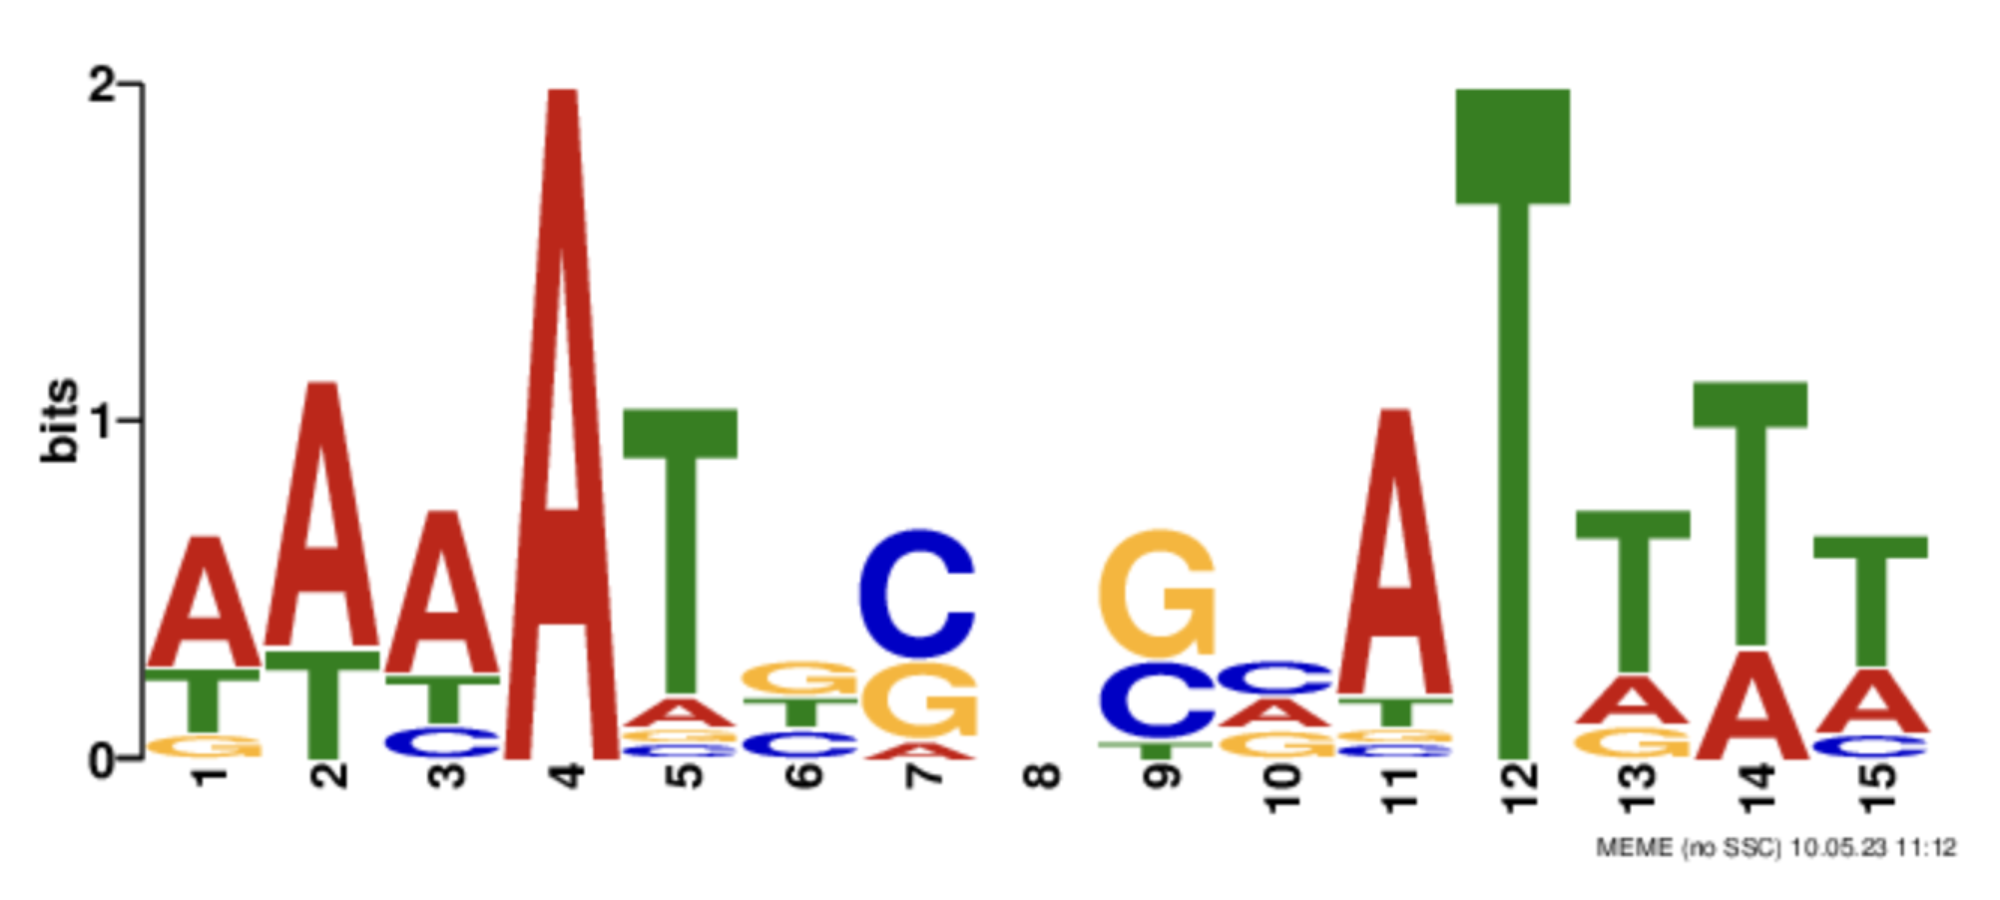

<Axes: >

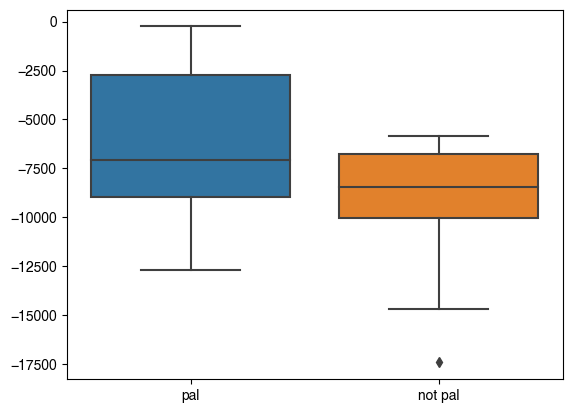

In [160]:
pal = sum(val_scores_pal, [])
pal_x = ['pal'] * len(pal)
no_pal = sum(val_scores, [])
no_pal_x = ['not pal'] * len(no_pal)
sns.boxplot(x=pal_x+no_pal_x, y=pal+no_pal)

In [161]:
training_scores, val_scores = Meme_LOO('Lrp', pal=False, distr=True, mod='anr')
training_scores_pal, val_scores_pal = Meme_LOO('Lrp', pal=True, distr=True, mod='anr')

val_scores_split_pal = Meme_LOO_split('Lrp', spacer_len=2, mod='anr')

with open('data/Lrp_IM_motif_pal.pkl', 'wb') as f:
    pickle.dump(val_scores_pal, f)
with open('data/Lrp_IM_motif.pkl', 'wb') as f:
    pickle.dump(val_scores, f)
with open('data/Lrp_IM_motif_split_pal.pkl', 'wb') as f:
    pickle.dump(val_scores_split_pal, f)

The output directory 'meme_out' already exists.
Its contents will be overwritten.
Initializing the motif probability tables for 2 to 50 sites...
nsites = 50
Done initializing.
SEEDS: highwater mark: seq 18 pos 209

seqs=    19, min= 180, max=  209, total=     3449

motif=1
SEED WIDTHS: 6 8 11 15 21 29 41 50
em: w=  50, psites=  32, iter=   0   
The output directory 'meme_out' already exists.
Its contents will be overwritten.
Initializing the motif probability tables for 2 to 50 sites...
nsites = 50
Done initializing.
SEEDS: highwater mark: seq 18 pos 360

seqs=    19, min= 180, max=  360, total=     3600

motif=1
SEED WIDTHS: 6 8 11 15 21 29 41 50
em: w=  50, psites=  50, iter=  20   
The output directory 'meme_out' already exists.
Its contents will be overwritten.
Initializing the motif probability tables for 2 to 50 sites...
nsites = 50
Done initializing.
SEEDS: highwater mark: seq 18 pos 360

seqs=    19, min= 180, max=  360, total=     3629

motif=1
SEED WIDTHS: 6 8 11 15 21 29 41 

em: w=  51, psites=  50, iter=  20   
The output directory 'meme_out' already exists.
Its contents will be overwritten.
Initializing the motif probability tables for 4 to 100 sites...
nsites = 100
Done initializing.
SEEDS: highwater mark: seq 18 pos 360

seqs=    19, min= 180, max=  360, total=     3629

motif=1
SEED WIDTHS: 6 7 8 9 11 12 15 16 21 22 29 30 41 42 50 51
em: w=  51, psites=  50, iter=  40   
The output directory 'meme_out' already exists.
Its contents will be overwritten.
Initializing the motif probability tables for 4 to 100 sites...
nsites = 100
Done initializing.
SEEDS: highwater mark: seq 17 pos 209

seqs=    18, min= 180, max=  360, total=     3449

motif=1
SEED WIDTHS: 6 7 8 9 11 12 15 16 21 22 29 30 41 42 50 51
em: w=  51, psites=  32, iter=  30   
The output directory 'meme_out' already exists.
Its contents will be overwritten.
Initializing the motif probability tables for 4 to 100 sites...
nsites = 100
Done initializing.
SEEDS: highwater mark: seq 18 pos 209

seq

em: w=  51, psites=  50, iter=  20   
The output directory 'meme_out' already exists.
Its contents will be overwritten.
Initializing the motif probability tables for 4 to 100 sites...
nsites = 100
Done initializing.
SEEDS: highwater mark: seq 18 pos 360

seqs=    19, min= 180, max=  360, total=     3629

motif=1
SEED WIDTHS: 6 7 8 9 11 12 15 16 21 22 29 30 41 42 50 51
em: w=  51, psites=  50, iter=  30   
The output directory 'meme_out' already exists.
Its contents will be overwritten.
Initializing the motif probability tables for 4 to 100 sites...
nsites = 100
Done initializing.
SEEDS: highwater mark: seq 17 pos 360

seqs=    18, min= 180, max=  360, total=     3449

motif=1
SEED WIDTHS: 6 7 8 9 11 12 15 16 21 22 29 30 41 42 50 51
em: w=  51, psites=  32, iter=  20   
